In [16]:
import pandas as pd
import numpy as np
from keras.models import Model,Sequential,load_model
from keras.layers import Dense, Embedding, Input,\
                                    Dropout,BatchNormalization, Activation,\
                                   Conv2D,Flatten,LeakyReLU,MaxPooling2D, Conv2DTranspose,Reshape,UpSampling2D,GaussianNoise
from keras import optimizers
from keras.callbacks import TensorBoard, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from sklearn import cluster
import time
import re
import os

In [2]:
DIR_MAC= '/Users/haipengwu/Codings/Machine Learning/HW7/'
DIR_1080="C:\\Users\\WIN10\\Codings\\Machine Learning\\HW7\\"

DIR = DIR_1080
TRAIN_DIR= DIR+ "images\\train"
VALIDATION_DIR = DIR+ "images\\validation"
TEST_DIR = DIR+ "images\\test"



## Image load and augmentation

In [39]:
BATCH_SIZE = 200
IMG_SIZE = 32

train_datagen = ImageDataGenerator(
        rescale = 1./255,
        samplewise_center=False,
        samplewise_std_normalization=False,
        shear_range=0.3,
        zoom_range=0.3,
        rotation_range=0.3,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip = True)

train_generator = train_datagen.flow_from_directory(
        TRAIN_DIR,
        target_size=(IMG_SIZE,IMG_SIZE),
        batch_size = BATCH_SIZE,
        shuffle= False,
        class_mode = 'input')

validation_datagen = ImageDataGenerator(
        rescale = 1./255)

validation_generator = validation_datagen.flow_from_directory(
        VALIDATION_DIR,
        target_size=(IMG_SIZE,IMG_SIZE),
        batch_size = BATCH_SIZE,
        shuffle= False,
        class_mode = 'input')

test_datagen = ImageDataGenerator(
        rescale = 1./255)

test_generator = test_datagen.flow_from_directory(
        TEST_DIR,
        target_size=(IMG_SIZE,IMG_SIZE),
        batch_size = BATCH_SIZE,
        shuffle= False,
        class_mode = 'input')

Found 36000 images belonging to 1 classes.
Found 4000 images belonging to 1 classes.
Found 40000 images belonging to 1 classes.


In [18]:
test_generator.filenames[:10]

['1\\000001.jpg',
 '1\\000002.jpg',
 '1\\000003.jpg',
 '1\\000004.jpg',
 '1\\000005.jpg',
 '1\\000006.jpg',
 '1\\000007.jpg',
 '1\\000008.jpg',
 '1\\000009.jpg',
 '1\\000010.jpg']

## Autoencoder model

In [40]:
encoding_dim = 1000

def auto_encoder():
    
    #Encoding
    input_img = Input(shape = (IMG_SIZE,IMG_SIZE,3))
#     encoded = GaussianNoise(0.1)
    encoded = Conv2D(32,kernel_size=3,strides = 1,input_shape=(IMG_SIZE,IMG_SIZE,3),padding='SAME' )(input_img)
    encoded =MaxPooling2D(pool_size=(2,2))(encoded)
    encoded =BatchNormalization(momentum=.9)(encoded)
    encoded =Activation('relu')(encoded)
    
    encoded = Conv2D(32,kernel_size=3,strides = 1,padding='SAME' )(encoded)
    encoded = MaxPooling2D(pool_size=(2,2))(encoded)
    encoded = BatchNormalization(momentum=.9)(encoded)
    encoded = Activation('relu')(encoded)
#     encoded = Dropout(0.5)(encoded)
    
    encoded = Flatten()(encoded)    

    
    ##Code layer to 'encoding_dim' dimensions
    code_layer_output = Dense(encoding_dim,activation='tanh')(encoded)
    
    ##Decoding
    
    decoded = Dense(8*8*32,activation='relu')(code_layer_output)
    
    decoded=Reshape((8,8,32))(decoded)
    
    decoded=Conv2DTranspose(32,kernel_size=3,strides=1,padding="SAME")(decoded)
    decoded=UpSampling2D(size=(2,2))(decoded)
    decoded=BatchNormalization(momentum=.9)(decoded)
    decoded=Activation('relu')(decoded)
    
    decoded=Conv2DTranspose(32,kernel_size=3,strides=1,padding="SAME")(decoded)
    decoded=UpSampling2D(size=(2,2))(decoded)
    decoded=BatchNormalization(momentum=.9)(decoded)
    decoded=Activation('relu')(decoded)  
    
    decoded=Conv2DTranspose(3,kernel_size=3,strides=1,padding="SAME")(decoded)
    decoded_output = Activation('sigmoid')(decoded)
    
    

           
    auto_encoder = Model(inputs = input_img, outputs = decoded_output)
    auto_encoder.summary()
    
    

    code_layer =Model(inputs = input_img, outputs = code_layer_output)
    code_layer.summary()
    

    
    return auto_encoder, code_layer


## Training the autoencoder, and extract the code layer model for code generation

In [41]:
model,code_layer_model = auto_encoder()


adam_optimizer = optimizers.Adam(lr=1e-3, decay=1e-6)
model.compile(loss='mse',optimizer=adam_optimizer,metrics=['accuracy'])
# set tensorboard
NAME = "Img_Clustering-{}".format(int(time.time()))
tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

#set modelcheckpoint

MODELSAVENAME = "model\\Img_Clustering_Best.h5"
checkpoint = ModelCheckpoint(DIR+"{}".format(MODELSAVENAME),monitor='val_acc', \
                                                      verbose=1, save_best_only=True, mode='max') # saves only the best ones

model.fit_generator(
        train_generator,
        steps_per_epoch = 36000 / BATCH_SIZE,
        epochs = 50,
        validation_data = validation_generator,
        validation_steps = 4000 / BATCH_SIZE,
        callbacks = [tensorboard])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
batch_normalization_17 (Batc (None, 16, 16, 32)        128       
_________________________________________________________________
activation_21 (Activation)   (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 16, 16, 32)        9248      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 8, 8, 32)          0         
__________

In [55]:
model.fit_generator(
        train_generator,
        steps_per_epoch = 36000 / BATCH_SIZE,
        epochs = 20,
        validation_data = validation_generator,
        validation_steps = 4000 / BATCH_SIZE)

Epoch 1/20
180/180 [==============================] - 41s 226ms/step - loss: 0.0023 - acc: 0.8749 - val_loss: 0.0040 - val_acc: 0.8664 0.0023 - acc: 0.874 - ETA: 2s - loss: 0.0023 - 
Epoch 2/20
180/180 [==============================] - 41s 225ms/step - loss: 0.0023 - acc: 0.8751 - val_loss: 0.0040 - val_acc: 0.8588 - loss: 0.0023 - acc:  - ETA: 12s - lo - ETA: 0s - loss: 0.0023 - acc: 0.
Epoch 3/20
180/180 [==============================] - 39s 217ms/step - loss: 0.0023 - acc: 0.8758 - val_loss: 0.0040 - val_acc: 0.8671
Epoch 4/20
180/180 [==============================] - 39s 217ms/step - loss: 0.0023 - acc: 0.8763 - val_loss: 0.0038 - val_acc: 0.8680
Epoch 5/20
180/180 [==============================] - 39s 215ms/step - loss: 0.0023 - acc: 0.8767 - val_loss: 0.0039 - val_acc: 0.8677
Epoch 6/20
180/180 [==============================] - 39s 217ms/step - loss: 0.0023 - acc: 0.8766 - val_loss: 0.0040 - val_acc: 0.8633
Epoch 7/20
180/180 [==============================] - 39s 216ms/step

In [56]:
# Save the autoencoder
AUTOENCODER_SAVE_NAME= "model\\autoencoder.h5"
model.save(DIR+AUTOENCODER_SAVE_NAME)


# Save the code_layer_model 
CODE_LAYER_SAVE_NAME= "model\\code_layer_model.h5"
code_layer_model.save(DIR+CODE_LAYER_SAVE_NAME)

## if above training codes are not run, run below optional block to load the models

In [43]:
# Load model:
AUTOENCODER_SAVE_NAME= "model\\autoencoder.h5"
model = load_model(AUTOENCODER_SAVE_NAME)


# code is (100,) shape
CODE_LAYER_SAVE_NAME= "model\\code_layer_model.h5"
code_layer_model = load_model(CODE_LAYER_SAVE_NAME)



## Build code dictionary array

In [57]:
test_generator.reset()
code_dictionary_array = code_layer_model.predict_generator(test_generator,steps = 40000/BATCH_SIZE )

## Check if the code works

In [58]:
import matplotlib.pyplot as plt
from skimage import io
%matplotlib inline

test_generator.reset()
generated_image = model.predict_generator(test_generator,steps = 40000/BATCH_SIZE)


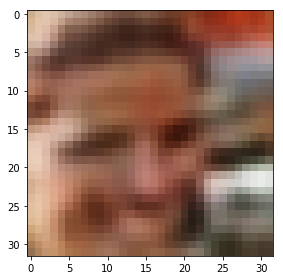

In [59]:
io.imshow(generated_image[2])

## Use PCA to reduce the code vector, which will boost the discrimination. with PCA:0.96, without PCA: 0.6 !

In [60]:
from sklearn.decomposition import PCA
reduced_dim = 500

# set n_components= 0.99 if you want the number of dimensions(components) corresponds to 99% of the variance
pca = PCA(n_components=reduced_dim, whiten=True , copy = False, svd_solver ='full')
final_latent_code = pca.fit_transform(code_dictionary_array)

In [48]:
pca.explained_variance_ratio_

array([1.08714245e-01, 6.86981678e-02, 4.97138314e-02, 4.27409522e-02,
       3.33447158e-02, 3.05652246e-02, 2.98274793e-02, 2.63231564e-02,
       2.31066030e-02, 2.02045254e-02, 1.51523966e-02, 1.39007010e-02,
       1.29959527e-02, 1.18492283e-02, 1.13601871e-02, 1.04989475e-02,
       9.97801125e-03, 9.47961584e-03, 8.90864246e-03, 8.33202805e-03,
       8.11758172e-03, 7.92022422e-03, 7.64848385e-03, 7.14610144e-03,
       7.11172586e-03, 6.96396362e-03, 6.61390787e-03, 6.34532934e-03,
       6.24405360e-03, 5.97041147e-03, 5.75119397e-03, 5.43601532e-03,
       5.28219203e-03, 5.16289379e-03, 5.07031288e-03, 5.01732482e-03,
       4.73434851e-03, 4.55436017e-03, 4.48884116e-03, 4.39408794e-03,
       4.29226272e-03, 4.22861194e-03, 4.16514510e-03, 4.05204948e-03,
       3.89520708e-03, 3.86338122e-03, 3.81527632e-03, 3.71637102e-03,
       3.62637779e-03, 3.52946250e-03, 3.42688570e-03, 3.39652970e-03,
       3.32516502e-03, 3.23008024e-03, 3.16350465e-03, 3.11915786e-03,
      

## Try t-SNE. t-SNE is normally used for visualization. so try to set n_components = 2 to visualize the transformed latent codes

In [ ]:
from sklearn.manifold import TSNE

# tsne = TSNE(n_components=2,random_state=0)
# final_latent_code_visualize = tsne.fit_transform(code_dictionary_array)


## Build discrimination function using K-means clustering

In [61]:
from sklearn.cluster import KMeans 


kmeans = KMeans(n_clusters=2, random_state=0).fit(final_latent_code)

def discriminate(img1_num,img2_num):
    
    #if two pics are in the same cluster, with same label, then return 1, otherwise return 0
    if kmeans.labels_[img1_num - 1] == kmeans.labels_[img2_num - 1]:
        return 1
    else:
        return 0    

    

In [62]:
kmeans.labels_[:100]

array([1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0,
       1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0,
       1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0,
       1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0,
       1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0])

## load testcase.csv and output Result

In [63]:
import pandas as pd
testcase = pd.read_csv(DIR + "test_case.csv")
feature_names = ["image1_name","image2_name"]
testcase_image_pair = testcase[feature_names].values
testcase_image_pair[20]

array([26433, 24161], dtype=int64)

In [64]:
results = [discriminate(testcase_image_pair[i][0],testcase_image_pair[i][1]) for i in range(testcase_image_pair.shape[0])]

In [65]:
sample_submission = pd.read_csv(DIR+'sample_submission.csv')
sample_submission ['label'] = results

In [66]:
sample_submission.to_csv("submission_wu.csv",index=False)